# Getting started with PyMC3

[PeerJ CS publication on PyMC3](https://peerj.com/articles/cs-55/).

## Introduction

Probabilistic Programming allows for automatic Bayesian inference on user-defined probabilistic models. Recent advances in Markov chain Monte Carlo (MCMC) sampling allow inference on increasingly complex models. 

Here, we present a primer on the use of PyMC3 for solving general Bayesian statistical inference and prediction problems. We will first see the basics of how to use PyMC3, motivated by a simple example: installation, data creation, model definition, model fitting and posterior analysis. Then we will cover a case study and use them to show how to define and fit more sophisticated models. 

## Installation

Running PyMC3 requires a working Python interpreter, either version 2.7 (or more recent) or 3.5 (or more recent); we recommend that new users install version 3.5. A complete Python installation for Mac OSX, Linux and Windows can most easily be obtained by downloading and installing the free [`Anaconda Python Distribution`](https://store.continuum.io/cshop/anaconda/).

`PyMC3` can be installed using ["pip"](https://pip.pypa.io/en/latest/installing.html):

```
pip install pymc3
```

Or via conda:

```
conda install pymc3
```

The current development branch of PyMC3 can be installed from GitHub, also using pip:

```
pip install git+https://github.com/pymc-devs/pymc3
```



We are going to use a file called environment.yml that includes a list of all the packages. 

If you run:

    conda env create


## A Motivating Example: Linear Regression

To introduce model definition, fitting and posterior analysis, we first consider a simple Bayesian linear regression model with normal priors for the parameters. We are interested in predicting outcomes $Y$ as normally-distributed observations with an expected value $\mu$ that is a linear function of two predictor variables, $X_1$ and $X_2$.

$$\begin{aligned} 
Y  &\sim \mathcal{N}(\mu, \sigma^2) \\
\mu &= \alpha + \beta_1 X_1 + \beta_2 X_2
\end{aligned}$$

where $\alpha$ is the intercept, and $\beta_i$ is the coefficient for covariate $X_i$, while $\sigma$ represents the observation error. Since we are constructing a Bayesian model, we must assign a prior distribution to the unknown variables in the model. We choose zero-mean normal priors with variance of 100 for both regression coefficients, which corresponds to *weak* information regarding the true parameter values. We choose a half-normal distribution (normal distribution bounded at zero) as the prior for $\sigma$.

$$\begin{aligned} 
\alpha &\sim \mathcal{N}(0, 100) \\
\beta_i &\sim \mathcal{N}(0, 100) \\
\sigma &\sim \lvert\mathcal{N}(0, 1){\rvert}
\end{aligned}$$

### Generating data

We can simulate some artificial data from this model using only NumPy's `random` module, and then use PyMC3 to try to recover the corresponding parameters. We are intentionally generating the data to closely correspond the PyMC3 model structure.

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

In [3]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [9]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + np.random.randn(size) * sigma

Here is what the simulated data look like. We use the `pylab` module from the plotting library matplotlib. 

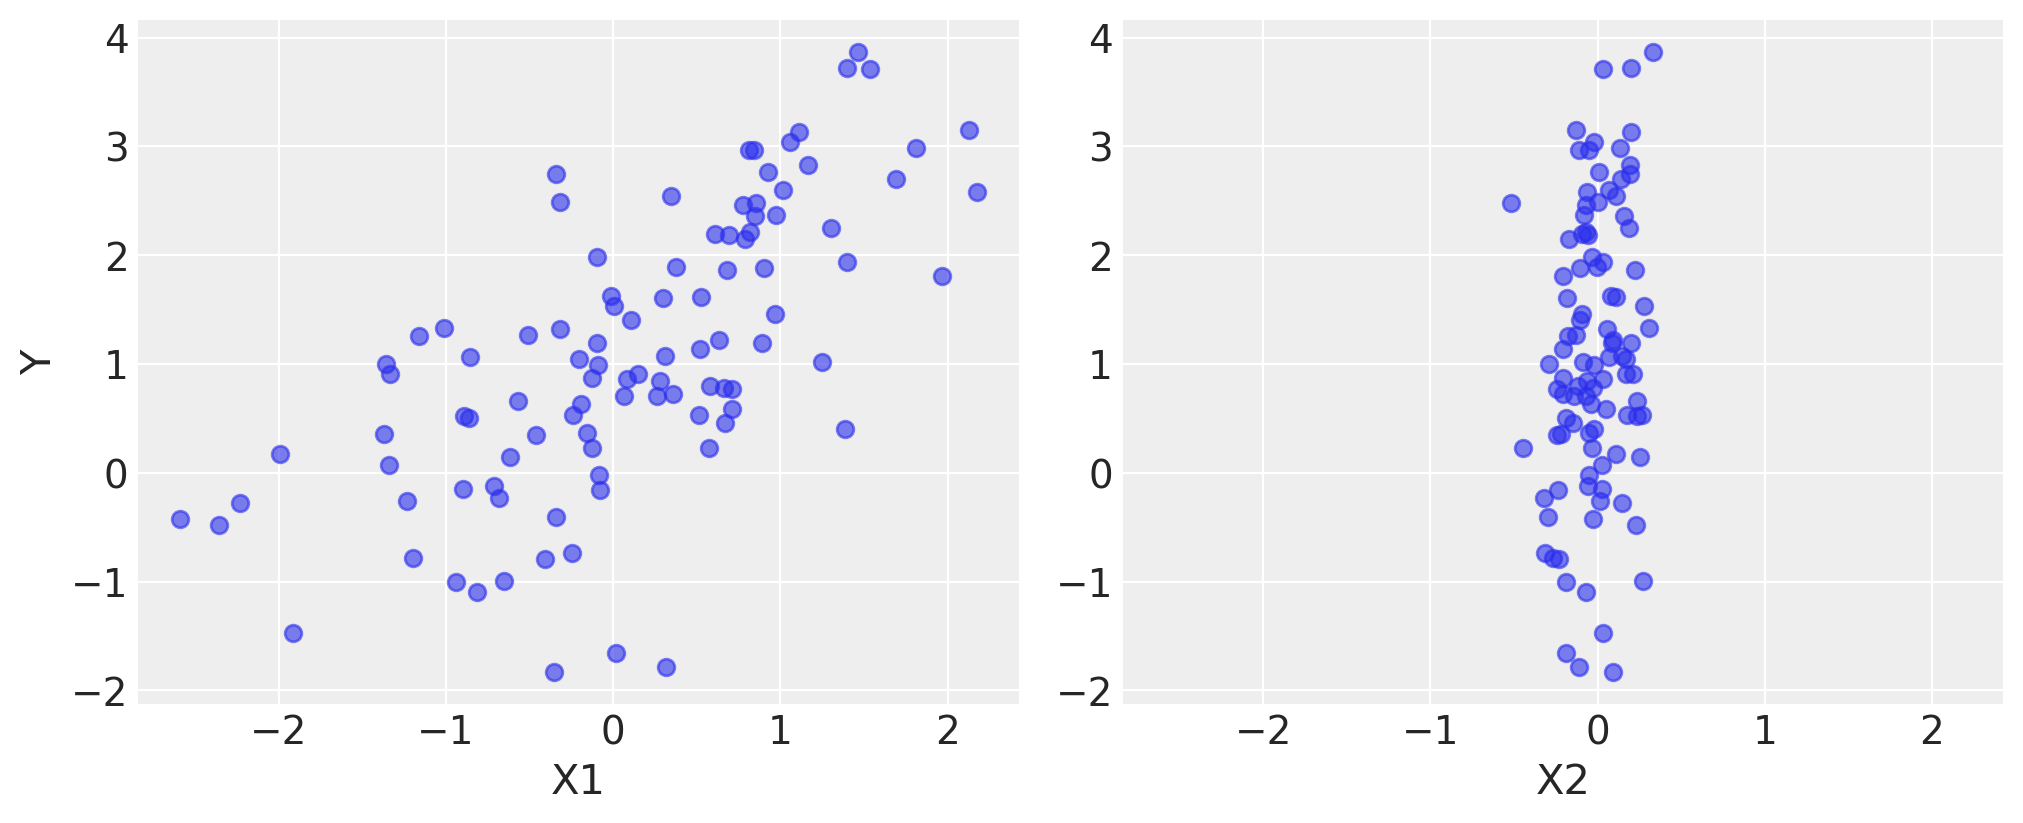

In [10]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

### Model Specification

Specifying this model in PyMC3 is straightforward because the syntax is as close to the statistical notation. For the most part, each line of Python code corresponds to a line in the model notation above. 

First, we import PyMC. We use the convention of importing it as `pm`.

In [11]:
import pymc3 as pm

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.9.3


Now we build our model, which we will present in full first, then explain each part line-by-line.

In [ ]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)
    

The first line,

```python
basic_model = Model()
```

creates a new `Model` object which is a container for the model random variables.

Following instantiation of the model, the subsequent specification of the model components is performed inside a  `with` statement:

```python
with basic_model:
```
This creates a *context manager*, with our `basic_model` as the context, that includes all statements until the indented block ends. This means all PyMC3 objects introduced in the indented code block below the `with` statement are added to the model behind the scenes. Absent this context manager idiom, we would be forced to manually associate each of the variables with `basic_model` right after we create them. If you try to create a new random variable without a `with model:` statement, it will raise an error since there is no obvious model for the variable to be added to.

The first three statements in the context manager:

```python
alpha = Normal('alpha', mu=0, sigma=10)
beta = Normal('beta', mu=0, sigma=10, shape=2)
sigma = HalfNormal('sigma', sigma=1)
```
create **stochastic** random variables with Normal prior distributions for the regression coefficients with a mean of 0 and standard deviation of 10, and a half-normal distribution for the standard deviation of the observations, $\sigma$. These are stochastic because their values are partly determined by its parents in the dependency graph of random variables, which for priors are simple constants, and partly random (or stochastic). 

We call the `Normal` constructor to create a random variable to use as a normal prior. The first argument is always the *name* of the random variable, which should almost always match the name of the Python variable being assigned to, since it is sometimes used to retrieve the variable from the model for summarizing output. The remaining required arguments for a stochastic object are the parameters, in this case `mu`, the mean, and `sd`, the standard deviation, which we assign hyperparameter values for the model. In general, a distribution's parameters are values that determine the location, shape or scale of the random variable, depending on the parameterization of the distribution. Most commonly used distributions, such as `Beta`, `Exponential`, `Categorical`, `Gamma`, `Binomial` and many others, are available in PyMC3.

The `beta` variable has an additional `shape` argument to denote it as a vector-valued parameter of size 2. The `shape` argument is available for all distributions and specifies the length or shape of the random variable, but is optional for scalar variables, since it defaults to a value of one. It can be an integer, to specify an array, or a tuple, to specify a multidimensional array (*e.g.* `shape=(5,7)` makes random variable that takes on 5 by 7 matrix values). 

Detailed notes about distributions, sampling methods and other PyMC3 functions are available in the [API documentation](https://docs.pymc.io/api.html).

Having defined the priors, the next statement creates the expected value `mu` of the outcomes, specifying the linear relationship:

```python
mu = alpha + beta[0]*X1 + beta[1]*X2
```
This creates a **deterministic** random variable, which implies that its value is *completely* determined by its parents' values. That is, there is no uncertainty beyond that which is inherent in the parents' values. Here, `mu` is just the sum of the intercept `alpha` and the two products of the coefficients in `beta` and the predictor variables, whatever their values may be. 

PyMC3 random variables and data can be arbitrarily added, subtracted, divided, multiplied together and indexed-into to create new random variables. This allows for great model expressivity. Many common mathematical functions like `sum`, `sin`, `exp` and linear algebra functions like `dot` (for inner product) and `inv` (for inverse) are also provided. 

The final line of the model, defines `Y_obs`, the sampling distribution of the outcomes in the dataset.

```python
Y_obs = Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
```

This is a special case of a stochastic variable that we call an **observed stochastic**, and represents the data likelihood of the model. It is identical to a standard stochastic, except that its `observed` argument, which passes the data to the variable, indicates that the values for this variable were observed, and should not be changed by any fitting algorithm applied to the model. The data can be passed in the form of either a `numpy.ndarray` or `pandas.DataFrame` object.

Notice that, unlike for the priors of the model, the parameters for the normal distribution of `Y_obs` are not fixed values, but rather are the deterministic object `mu` and the stochastic `sigma`. This creates parent-child relationships between the likelihood and these two variables.

### Model fitting

Having completely specified our model, the next step is to obtain posterior estimates for the unknown variables in the model. Ideally, we could calculate the posterior estimates analytically, but for most non-trivial models, this is not feasible. We will consider two approaches, whose appropriateness depends on the structure of the model and the goals of the analysis: finding the *maximum a posteriori* (MAP) point using optimization methods, and computing summaries based on samples drawn from the posterior distribution using Markov Chain Monte Carlo (MCMC) sampling methods.

#### Maximum a posteriori methods

The **maximum a posteriori (MAP)** estimate for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn't representative of the distribution. PyMC3 provides this functionality with the `find_MAP` function.

Below we find the MAP for our original model. The MAP is returned as a parameter **point**, which is always represented by a Python dictionary of variable names to NumPy arrays of parameter values. 

In [14]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'alpha': array(1.02069007),
 'beta': array([0.87013071, 1.63751414]),
 'sigma_log__': array(-0.09271107),
 'sigma': array(0.91145681)}

By default, `find_MAP` uses the Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimization algorithm to find the maximum of the log-posterior but also allows selection of other optimization algorithms from the `scipy.optimize` module. For example, below we use Powell's method to find the MAP.

In [8]:
map_estimate = pm.find_MAP(model=basic_model, method="powell")
map_estimate

/Users/ankitrawat/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method powell does not use gradient information (jac).
  RuntimeWarning)


{'alpha': array(0.95835519),
 'beta': array([1.1017629 , 2.95394057]),
 'sigma_log__': array(0.03638187),
 'sigma': array(1.03705179)}

It is important to note that the MAP estimate is not always reasonable, especially if the mode is at an extreme. This can be a subtle issue; with high dimensional posteriors, one can have areas of extremely high density but low total probability because the volume is very small. This will often occur in hierarchical models with the variance parameter for the random effect. If the individual group means are all the same, the posterior will have near infinite density if the scale parameter for the group means is almost zero, even though the probability of such a small scale parameter will be small since the group means must be extremely close together. 

Most techniques for finding the MAP estimate also only find a *local* optimum (which is often good enough), but can fail badly for multimodal posteriors if the different modes are meaningfully different.

In summary, while PyMC3 provides the function `find_MAP()`, at this point mostly for historical reasons, this function is of little use in most scenarios. If you want a point estimate you should get it from the posterior. In the next section we will see how to get a posterior using sampling methods.

#### Sampling methods

Though finding the MAP is a fast and easy way of obtaining estimates of the unknown model parameters, it is limited because there is no associated estimate of uncertainty produced with the MAP estimates. Instead, a simulation-based approach such as Markov chain Monte Carlo (MCMC) can be used to obtain a Markov chain of values that, given the satisfaction of certain conditions, are indistinguishable from samples from the _true_ posterior distribution. 

To conduct MCMC sampling to generate posterior samples in PyMC3, we specify a **step method** object that corresponds to a particular MCMC algorithm, such as Metropolis, Slice sampling, or the No-U-Turn Sampler (NUTS). PyMC3's `step_methods` submodule contains the following samplers: `NUTS`, `Metropolis`, `Slice`, `HamiltonianMC`, and `BinaryMetropolis`. These step methods can be assigned manually, or assigned automatically by PyMC3. Auto-assignment is based on the attributes of each variable in the model. In general:

* Binary variables will be assigned to `BinaryMetropolis`
* Discrete variables will be assigned to `Metropolis`
* Continuous variables will be assigned to `NUTS`

Auto-assignment can be overriden for any subset of variables by specifying them manually prior to sampling.

#### Gradient-based sampling methods

PyMC3 has the standard sampling algorithms like adaptive Metropolis-Hastings and adaptive slice sampling, but PyMC3's most capable step method is the No-U-Turn Sampler. NUTS is especially useful on models that have many continuous parameters, a situation where other MCMC algorithms work very slowly. It takes advantage of information about where regions of higher probability are, based on the gradient of the log posterior-density. This helps it achieve dramatically faster convergence on large problems than traditional sampling methods achieve. PyMC3 relies on Theano to analytically compute model gradients via automatic differentiation of the posterior density. NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo. For random variables that are undifferentiable (namely, discrete variables) NUTS cannot be used, but it may still be used on the differentiable variables in a model that contains undifferentiable variables. 

NUTS requires a scaling matrix parameter, which is analogous to the variance parameter for the jump proposal distribution in Metropolis-Hastings, although NUTS uses it somewhat differently. The matrix gives the rough shape of the distribution so that NUTS does not make jumps that are too large in some directions and too small in other directions. It is important to set this scaling parameter to a reasonable value to facilitate efficient sampling. This is especially true for models that have many unobserved stochastic random variables or models with highly non-normal posterior distributions. Poor scaling parameters will slow down NUTS significantly, sometimes almost stopping it completely. A reasonable starting point for sampling can also be important for efficient sampling, but not as often.

`PyMC3` automatically initializes NUTS to reasonable values based on the variance of the samples obtained during a tuning phase. A little bit of noise is added to ensure different, parallel, chains start from different points. Also, `PyMC3` will automatically assign an appropriate sampler if we don't supply it via the `step` keyword argument (see below for an example of how to explicitly assign step methods).

In [9]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 20 seconds.


The `sample` function runs the step method(s) assigned (or passed) to it for the given number of iterations and returns a `Trace` object containing the samples collected, in the order they were collected. The `trace` object can be queried in a similar way to a `dict` containing a map from variable names to `numpy.array`s. The first dimension of the array is the sampling index and the later dimensions match the shape of the variable. We can see the last 5 values for the `alpha` variable as follows:

In [10]:
trace["alpha"][-5:]

array([1.0590347 , 1.00385769, 0.8061283 , 0.6317241 , 0.70968829])

If we wanted to use the slice sampling algorithm to `sigma` instead of NUTS (which was assigned automatically), we could have specified this as the `step` argument for `sample`.

In [11]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(500, step=step, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 12 seconds.


### Posterior analysis
`PyMC3`'s plotting and diagnostics functionalities are now taken care of by a dedicated, platform-agnostic package named [ArviZ](https://arviz-devs.github.io/arviz/). A simple posterior plot can be created using `plot_trace`.

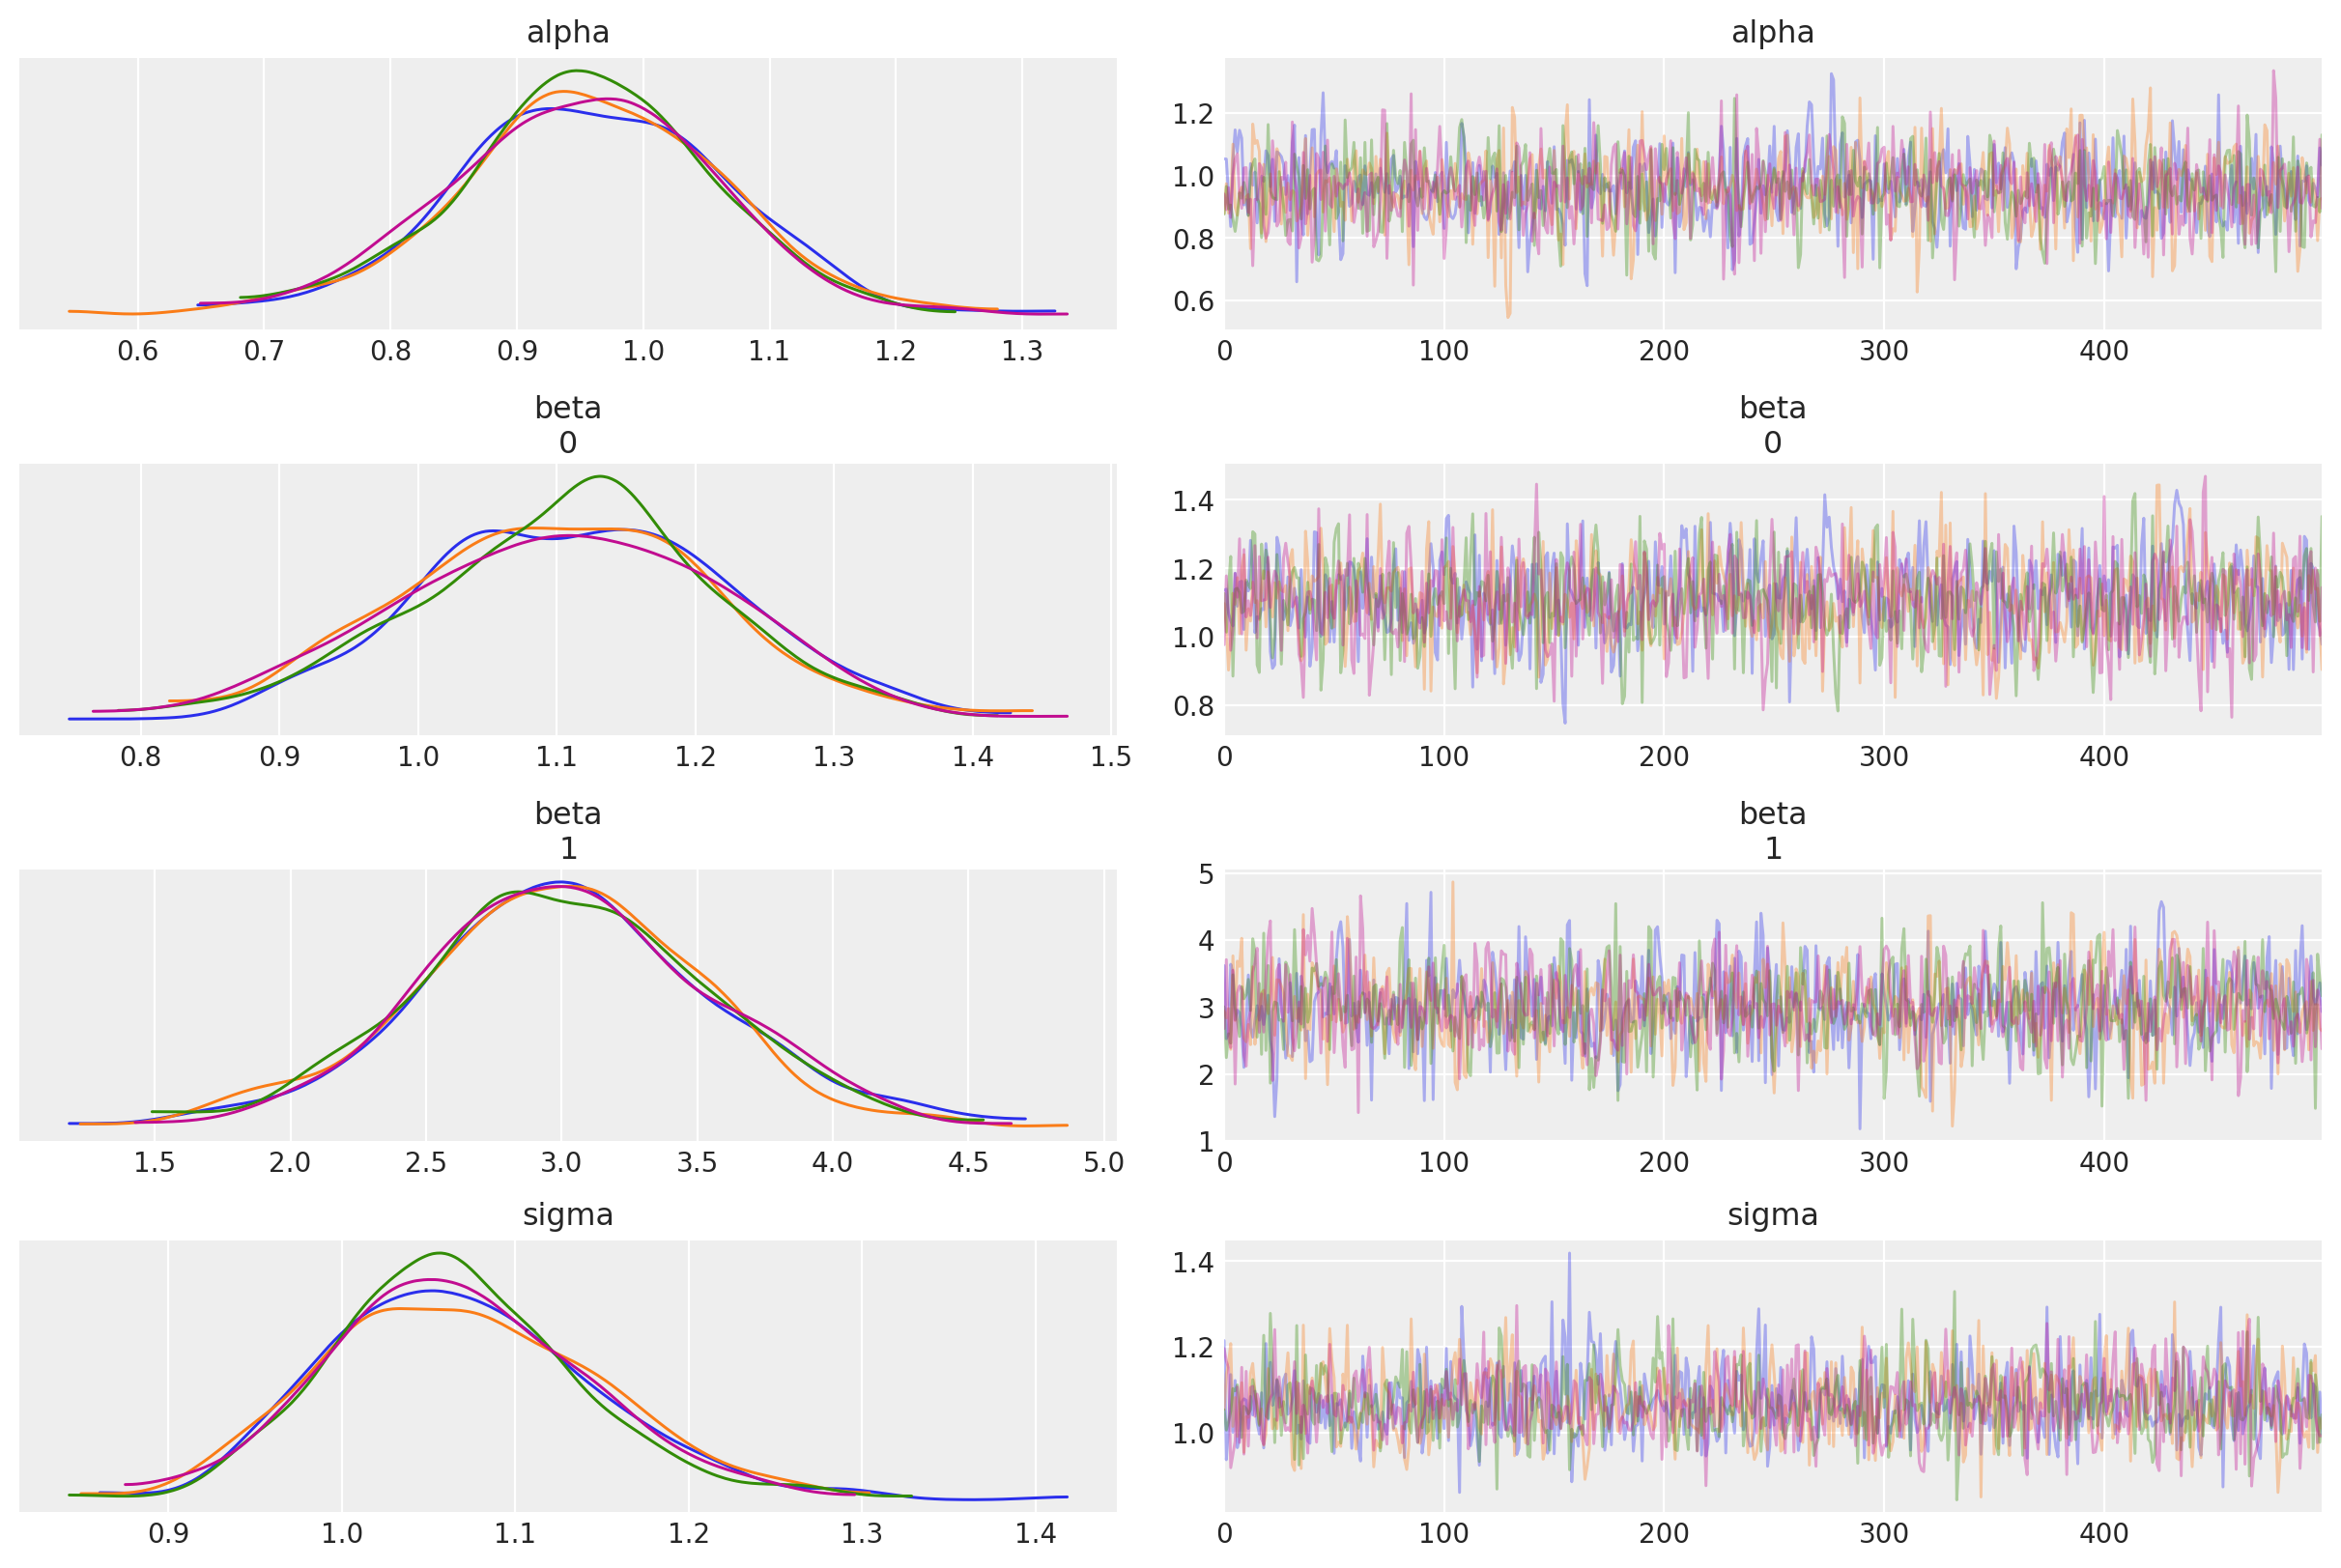

In [12]:
with basic_model:
    az.plot_trace(trace);

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The `beta` variable, being vector-valued, produces two histograms and two sample traces, corresponding to both predictor coefficients.

In addition, the `summary` function provides a text-based output of common posterior statistics:

In [13]:
with basic_model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.96,0.11,0.77,1.17,0.00,0.00,2039.04,2032.75,2046.81,1525.46,1.00
beta[0],1.11,0.11,0.88,1.31,0.00,0.00,1758.09,1747.16,1754.05,1539.90,1.00
beta[1],3.00,0.54,1.95,4.03,0.01,0.01,1872.97,1807.32,1877.26,1387.16,1.00
sigma,1.07,0.07,0.93,1.21,0.00,0.00,1920.94,1903.50,1929.84,1582.22,1.01


## Discussion

Probabilistic programming is an emerging paradigm in statistical learning, of which Bayesian modeling is an important sub-discipline. The signature characteristics of probabilistic programming--specifying variables as probability distributions and conditioning variables on other variables and on observations--makes it a powerful tool for building models in a variety of settings, and over a range of model complexity. Accompanying the rise of probabilistic programming has been a burst of innovation in fitting methods for Bayesian models that represent notable improvement over existing MCMC methods. Yet, despite this expansion, there are few software packages available that have kept pace with the methodological innovation, and still fewer that allow non-expert users to implement models.

PyMC3 provides a probabilistic programming platform for quantitative researchers to implement statistical models flexibly and succinctly. A large library of statistical distributions and several pre-defined fitting algorithms allows users to focus on the scientific problem at hand, rather than the implementation details of Bayesian modeling. The choice of Python as a development language, rather than a domain-specific language, means that PyMC3 users are able to work interactively to build models, introspect model objects, and debug or profile their work, using a dynamic, high-level programming language that is easy to learn. The modular, object-oriented design of PyMC3 means that adding new fitting algorithms or other features is straightforward. In addition, PyMC3 comes with several features not found in most other packages, most notably Hamiltonian-based samplers as well as automatical transforms of constrained random variables which is only offered by Stan. Unlike Stan, however, PyMC3 supports discrete variables as well as non-gradient based sampling algorithms like Metropolis-Hastings and Slice sampling.

Development of PyMC3 is an ongoing effort and several features are planned for future versions. Most notably, variational inference techniques are often more efficient than MCMC sampling, at the cost of generalizability. More recently, however, black-box variational inference algorithms have been developed, such as automatic differentiation variational inference (ADVI; Kucukelbir et al., 2017). This algorithm is slated for addition to PyMC3. As an open-source scientific computing toolkit, we encourage researchers developing new fitting algorithms for Bayesian models to provide reference implementations in PyMC3. Since samplers can be written in pure Python code, they can be implemented generally to make them work on arbitrary PyMC3 models, giving authors a larger audience to put their methods into use.

## References

Patil, A., D. Huard and C.J. Fonnesbeck. (2010) PyMC: Bayesian Stochastic Modelling in Python. Journal of Statistical Software, 35(4), pp. 1-81

Bastien, F., Lamblin, P., Pascanu, R., Bergstra, J., Goodfellow, I., Bergeron, A., Bouchard, N., Warde-Farley, D., and Bengio, Y. (2012) “Theano: new features and speed improvements”. NIPS 2012 deep learning workshop.

Bergstra, J., Breuleux, O., Bastien, F., Lamblin, P., Pascanu, R., Desjardins, G., Turian, J., Warde-Farley, D., and Bengio, Y. (2010) “Theano: A CPU and GPU Math Expression Compiler”. Proceedings of the Python for Scientific Computing Conference (SciPy) 2010. June 30 - July 3, Austin, TX

Lunn, D.J., Thomas, A., Best, N., and Spiegelhalter, D. (2000) WinBUGS -- a Bayesian modelling framework: concepts, structure, and extensibility. Statistics and Computing, 10:325--337.

Neal, R.M. Slice sampling. Annals of Statistics. (2003). doi:10.2307/3448413.

van Rossum, G. The Python Library Reference Release 2.6.5., (2010). URL http://docs.python.org/library/.

Duane, S., Kennedy, A. D., Pendleton, B. J., and Roweth, D. (1987) “Hybrid Monte Carlo”, Physics Letters, vol. 195, pp. 216-222.

Stan Development Team. (2014). Stan: A C++ Library for Probability and Sampling, Version 2.5.0.   http://mc-stan.org. 

Gamerman, D. Markov Chain Monte Carlo: statistical simulation for Bayesian inference. Chapman and Hall, 1997.

Hoffman, M. D., & Gelman, A. (2014). The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo. The Journal of Machine Learning Research, 30.

Kucukelbir A, Dustin Tran, Ranganath R, Gelman A, and Blei DM. Automatic differentiation variational inference
 http://arxiv.org/abs/1506.03431,  The Journal of Machine Learning Research. 18 , pp. 430-474 .

Vanderplas, Jake. "Frequentism and Bayesianism IV: How to be a Bayesian in Python." Pythonic Perambulations. N.p., 14 Jun 2014. Web. 27 May. 2015. <https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/>.

R.G. Jarrett. A note on the intervals between coal mining disasters. Biometrika, 66:191–193, 1979.


In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w

pymc3 3.9.3
numpy 1.18.1
arviz 0.10.0
last updated: Tue Nov 17 2020 

CPython 3.7.6
IPython 7.12.0
watermark 2.0.2
